In [221]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [222]:
data = pd.read_csv('../dataset/mammographic_masses.data', header=None)
data.columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

data = data.replace('?', np.nan) # replace ? with NaN
data = data.dropna()
data = data.astype('int') # convert all columns to int

print(data.shape)

(830, 6)


In [223]:
data.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
8,5,57,1,5,3,1
10,5,76,1,4,3,1


In [224]:
data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Benign:  51.45 % of the dataset
Malignant:  48.55 % of the dataset


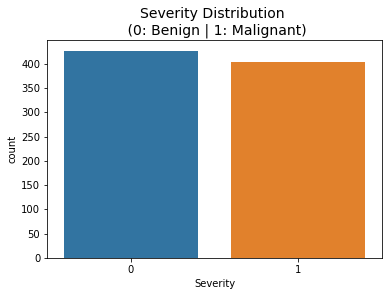

In [225]:
sns.countplot(x='Severity', data=data)
plt.title('Severity Distribution \n (0: Benign | 1: Malignant)', fontsize=14)

print('Benign: ', round(data['Severity'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Malignant: ', round(data['Severity'].value_counts()[1]/len(data) * 100,2), '% of the dataset')


Text(0.5, 1.0, 'Benign - Age')

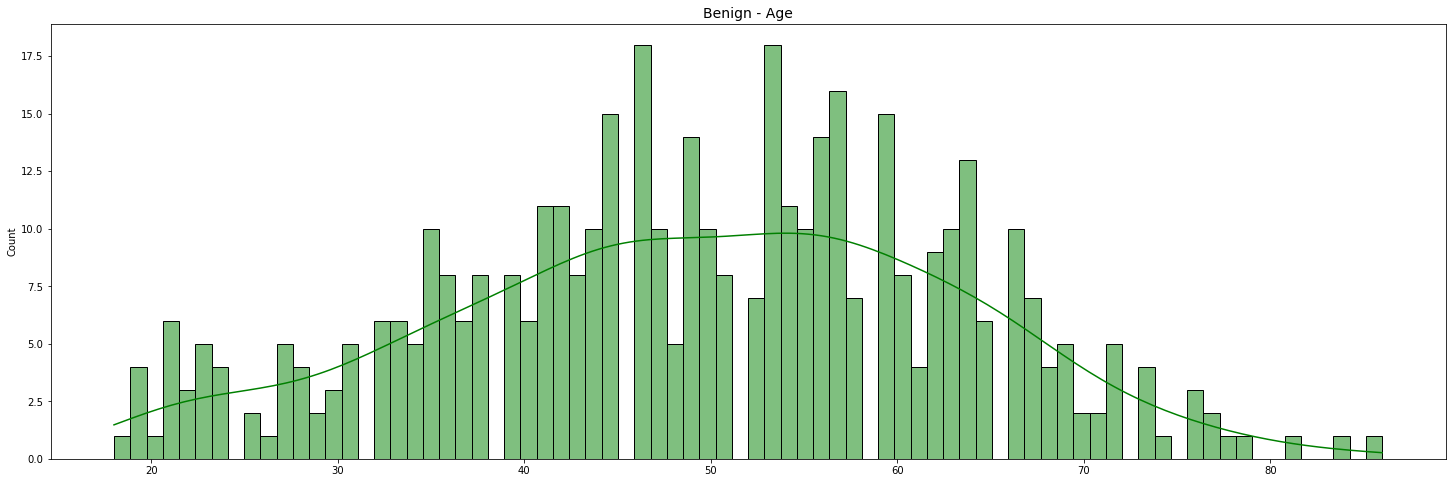

In [229]:
age_benign = data.Age[data.Severity == 0].values

bins = int(data['Age'].max()) - int(data['Age'].min())

plt.figure(figsize=(25,8))

sns.histplot(age_benign, bins=bins, kde=True, color='green', label='Benign')
plt.title('Benign - Age', fontsize=14)

Text(0.5, 1.0, 'Malignant - Age')

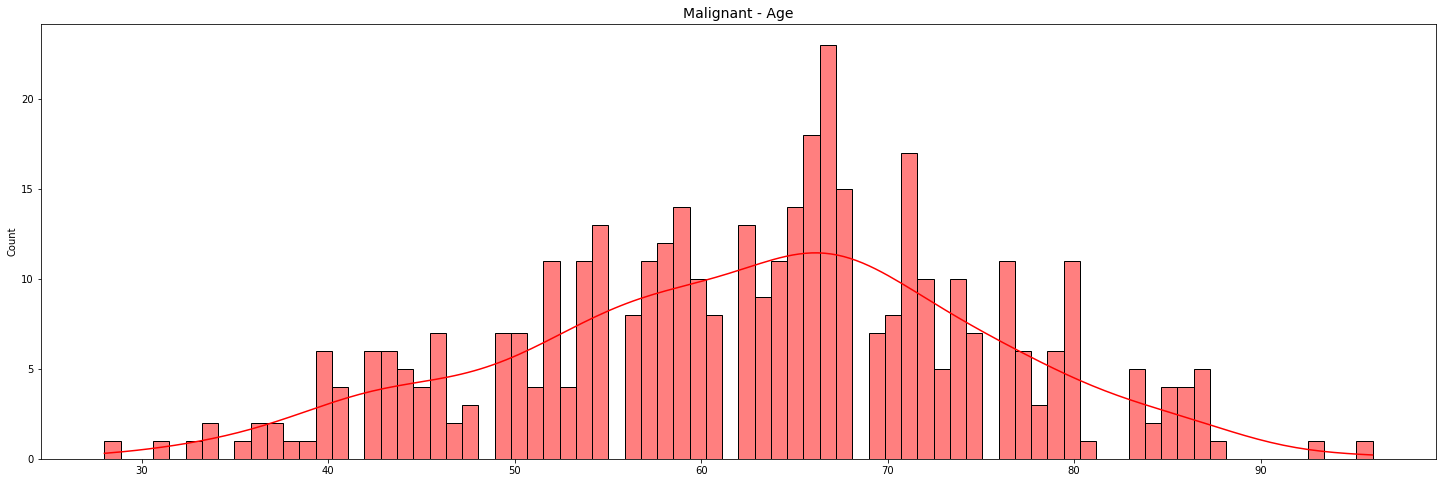

In [230]:
age_malign = data.Age[data.Severity == 1].values

bins = int(data['Age'].max()) - int(data['Age'].min())

plt.figure(figsize=(25,8))

sns.histplot(age_malign, bins=bins, kde=True, color='red', label='Malignant')
plt.title('Malignant - Age', fontsize=14)

Correlation Matrices

In [ ]:
corr = data.corr()

plt.figure(figsize=(10, 7))

sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Matrix', fontsize=14)

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20, 8))

sns.boxplot(x='Severity', y='Age', data=data, ax=axes[0])
axes[0].set_title('Severity - Age', fontsize=14) 

sns.boxplot(x='Severity', y='BI-RADS', data=data, ax=axes[1])
axes[1].set_title('Severity - BI-RADS', fontsize=14) 

sns.boxplot(x='Severity', y='Shape', data=data, ax=axes[2])
axes[2].set_title('Severity - Shape', fontsize=14)

sns.boxplot(x='Severity', y='Margin', data=data, ax=axes[3])
axes[3].set_title('Severity - Margin', fontsize=14) 


In [ ]:
data[data['BI-RADS'] == 6]

In [ ]:
data[data['BI-RADS'] == 0]

In [ ]:
plt.scatter(data['BI-RADS'], data['Age'])